In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

from klearn_tcyclone.utils import check_time_steps_TCTracks
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling, slide_by_scaling, get_top_k_ev_below_zero, train_model
from klearn_tcyclone.climada.utils import get_TCTrack_dict

from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official", year_range=(2000, 2011), basin="EP"
)

2024-11-23 11:15:18,347 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-11-23 11:15:37,325 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


<GeoAxes: >

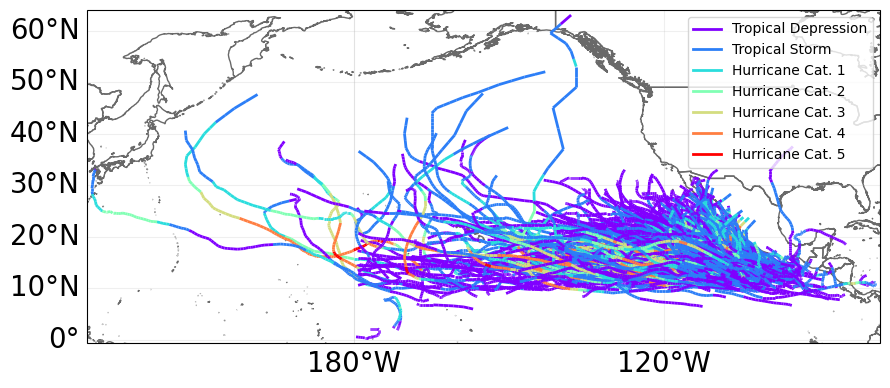

In [73]:
tc_tracks.plot()

In [13]:
context_length = 12
time_lag = 1
feature_list = ['lon', 'lat', 'max_sustained_wind', 'radius_max_wind', 'radius_oci', 'central_pressure', 'environmental_pressure']

In [14]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [98]:
from kooplearn.data import TensorContextDataset, TrajectoryContextDataset
from numpy.typing import NDArray
from klearn_tcyclone.data_utils import periodic_identification, periodic_shift, periodic_shift_TensorContextDataset

In [108]:
tcd = contexts["train"]

In [109]:
tcd.shape

(7588, 12, 7)

In [114]:
cmap1 = plt.cm.coolwarm
cmap2 = plt.cm.Greens

In [118]:
tcd_shifted = periodic_shift_TensorContextDataset(
    tcd, basin="EP"
)

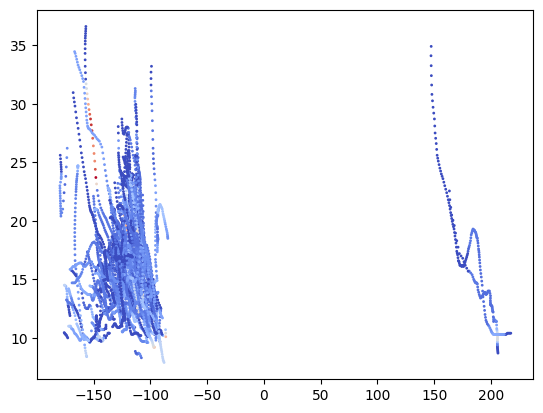

In [119]:
plt.scatter(tcd.data[:,0,0], tcd.data[:, 0, 1], c=tcd.data[:,0,3], cmap=cmap1, s=1)

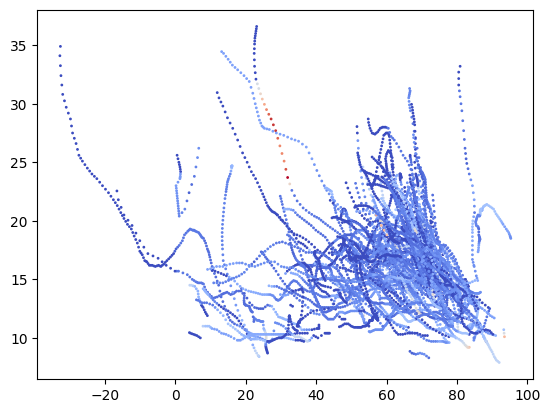

In [120]:
plt.scatter(tcd_shifted.data[:,0,0], tcd_shifted.data[:, 0, 1], c=tcd_shifted.data[:,0,3], cmap=cmap1, s=1)

In [121]:
scaler = LinearScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}